<a href="https://colab.research.google.com/github/siva4iov/VanillaRNN_first_name_generator/blob/main/Simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Here is a try to build Vanilla RNN Model

In [103]:
import tensorflow as tf

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [105]:
df = pd.read_csv("https://raw.githubusercontent.com/smashew/NameDatabases/master/NamesDatabases/first%20names/us.txt", names=["Name"])
df.sample(5)

,Name
2888,Lenny
354,Asley
361,Audra
3752,Norbert
3784,Olene


We have a daset with ~5k first names and our main idea to build model for generating names

In [106]:
len(df)

5163

Adding `start` tokens

In [107]:
df["Name"] = " " + df["Name"]

In [108]:
df["len"] = df["Name"].str.len()

# Distribution of lengths our names

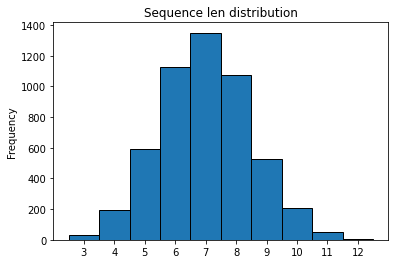

In [109]:
df["len"].plot(kind="hist", align="left", xticks=range(3,13), bins=range(3,14),
               edgecolor="k", title="Sequence len distribution")

# Dict of tokens

In [110]:
tokens = set(df["Name"].values.sum())
tokens = list(tokens)
display(f"number tokens: {len(tokens)}")

'number tokens: 53'

In [111]:
tokens_dict = {token: idx for idx, token in enumerate(tokens)}
tokens_dict[" "]

50

# Helper functions

Converting batch to matrix

In [112]:
max_len = df["len"].max()

In [113]:
def to_matrix(names, batch_first=True):
  names_ix = np.zeros([len(names), max_len], dtype=np.int32) + tokens_dict[" "]
  for i in range(len(names)):
    line_ix = [tokens_dict[c] for c in names[i]]
    names_ix[i, :len(line_ix)] = line_ix
  if not batch_first: #if not encoding batch
    names = np.transpose(names)
  return names_ix.squeeze()

In [114]:
print("\n".join(df["Name"].iloc()[451:456].values))
to_matrix(df["Name"].iloc()[451:456].values)

 Bernardine
 Bernardo
 Berneice
 Bernetta
 Bernice


array([[50, 37, 41, 40, 34, 43, 40, 30,  1, 34, 41, 50],
       [50, 37, 41, 40, 34, 43, 40, 30, 48, 50, 50, 50],
       [50, 37, 41, 40, 34, 41,  1, 12, 41, 50, 50, 50],
       [50, 37, 41, 40, 34, 41,  9,  9, 43, 50, 50, 50],
       [50, 37, 41, 40, 34,  1, 12, 41, 50, 50, 50, 50]], dtype=int32)

Text from sequence of indexes

In [115]:
def text_from_idx(seq):
  vals =  [tokens[i] for i in seq]
  return ["".join(vals)]

In [116]:
text_from_idx([5, 5 , 7 , 1 , 29 , 17])

['mmFiRl']

Indexes from sequence of symbols

In [117]:
def token_to_idx(token):
  return np.expand_dims([tokens_dict[symb] for symb in token], 0)


In [118]:
token_to_idx("Car")

array([[47, 43, 40]])

# Converting dataframe to tf dataset

In [119]:
data = to_matrix(df["Name"])

In [120]:
def split_to_target(sequence):
  train = sequence[:-1]
  target = sequence[1:]
  return train, target
split_to_target(list("nikita"))

(['n', 'i', 'k', 'i', 't'], ['i', 'k', 'i', 't', 'a'])

In [121]:

dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.map(split_to_target)
for i, k in dataset.take(2):
  print(f"input: {i}\ntarget: {k}")

input: [50 39 43 40 48 34 50 50 50 50 50]
target: [39 43 40 48 34 50 50 50 50 50 50]
input: [50 39 13 13 41 23 50 50 50 50 50]
target: [39 13 13 41 23 50 50 50 50 50 50]


In [122]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
dataset = (dataset
           .shuffle(BUFFER_SIZE)
           .batch(BATCH_SIZE, drop_remainder=True)
           .prefetch(tf.data.experimental.AUTOTUNE))


In [123]:
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 11), dtype=tf.int32, name=None), TensorSpec(shape=(64, 11), dtype=tf.int32, name=None))>

In [124]:
token_num_size = len(tokens_dict)

# The embedding dimension
embedding_dim = 16

# Number of RNN units
rnn_units = 64

# Building Model

We going to build vanilla rnn model like this:

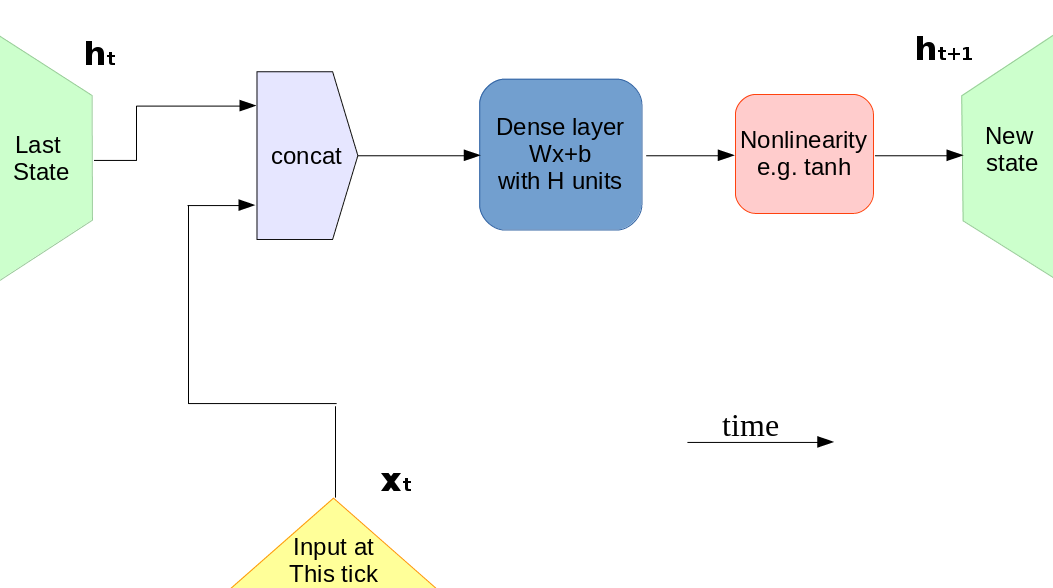

In [125]:
class MyModel(tf.keras.Model):
  def __init__(self, token_num_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.states = None
    self.embedding = tf.keras.layers.Embedding(token_num_size, embedding_dim)
    self.rnn = tf.keras.layers.SimpleRNN(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   )
    self.dense = tf.keras.layers.Dense(token_num_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs

    x = self.embedding(x, training=training)
    x, states = self.rnn(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [126]:
model = MyModel(token_num_size, embedding_dim, rnn_units)

Trying our model

In [127]:
for inp, targ in dataset.take(1):
  example = model(inp)
  print(example.shape)

(64, 11, 53)


In [128]:
sampled_indices = tf.random.categorical(example[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [129]:
print("Input:\n", text_from_idx(inp[0]))
print()
print("Next Char Predictions:\n", text_from_idx(sampled_indices))

Input:
 [' Cami      ']

Next Char Predictions:
 ['ncceVddpIzl']


# Training model

In [130]:
model = MyModel(token_num_size, embedding_dim, rnn_units)

In [131]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [132]:
example_batch_mean_loss = loss(targ, example)
print("Prediction shape: ", example.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 11, 53)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(3.9454865, shape=(), dtype=float32)


In [133]:
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.003))

In [134]:
EPOCHS=60

In [135]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/60
80/80 [==============================] - 2s 10ms/step - loss: 2.0555
Epoch 2/60
80/80 [==============================] - 1s 8ms/step - loss: 1.6543
Epoch 3/60
80/80 [==============================] - 1s 15ms/step - loss: 1.5385
Epoch 4/60
80/80 [==============================] - 1s 15ms/step - loss: 1.4749
Epoch 5/60
80/80 [==============================] - 2s 17ms/step - loss: 1.4358
Epoch 6/60
80/80 [==============================] - 1s 17ms/step - loss: 1.4094
Epoch 7/60
80/80 [==============================] - 2s 19ms/step - loss: 1.3867
Epoch 8/60
80/80 [==============================] - 1s 16ms/step - loss: 1.3743
Epoch 9/60
80/80 [==============================] - 1s 16ms/step - loss: 1.3550
Epoch 10/60
80/80 [==============================] - 1s 16ms/step - loss: 1.3519
Epoch 11/60
80/80 [==============================] - 1s 15ms/step - loss: 1.3310
Epoch 12/60
80/80 [==============================] - 1s 10ms/step - loss: 1.3276
Epoch 13/60
80/80 [===================

### Helper generating function

In [136]:
def generate_sample(model, inputs, states=None):
  inputs = token_to_idx(inputs)
  # print(inputs)
  pred_logits, state = model(inputs, states=states, return_state=True)
  pred_logits = pred_logits[:, -1, :]
  predicted_ids = tf.random.categorical(pred_logits, num_samples=1)
  predicted_ids = tf.squeeze(predicted_ids, axis=-1)
  predicted_chars = text_from_idx(predicted_ids)
  return predicted_chars, states


In [137]:
def generate(seed: str=" ", leng: int=max_len):
  next_char = seed
  states = None
  result = [[next_char]]
  for n in range(leng+1-len(next_char)):
    # print(f"{n} step:")
    next_char, states = generate_sample(model, next_char, states=states)
    # print(next_char)
    result.append(next_char)
  result = np.array(result)
  print("".join(np.stack(result, 1).squeeze()))

Example of generating

In [138]:
for _ in range(10):
  generate("Nast", 8)

Nastoloby
Nastophan
Nastelian
Nastoneri
Nastonans
Nasthanan
Nastoniaj
Nastceshh
Nastolone
Nastonani
